In [1]:
import numpy as np
import xsimlab as xs
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Let's take notes again,

so I should put every process into a process class

but that creates problems! what about parameters?
- i need to create an instance of the process class, within the components, actually... (?) 

also, what about the fluxes?



This is a central question right now, what is the best way to structure the package, based on xsimlab

xsimlab was not written for my kind of applications, it actually is more suitable for agent-based models
i'm doing equation based modeling..

### and at some point in my model I need to define the *_fluxes_*

but where is best? prob in the environment, right? but then what about modification of the ODE?

## what if I put the ODE in a seperate class? would that make any sense?

MODELICA - interesting source on this: https://portal.research.lu.se/ws/files/4779081/8571901.pdf

It defines all components + params + additionally the model equation! (this is missing from xsimlab, somehow--)


In [2]:
IDEa: can keep equation construction separate from model assembly, check all components present before?

Object `before` not found.


In [3]:
could also keep all "MATHS FUNX" outside of xsimlab..

would that increase usability??

I need some way to contruct ODE systems, one component has one flux, right?

so perhaps that is the way, have each component assemble it's flux, and that is passed on to final model

but then how do components interact? components inherits all processes that are part of it's flux, and then later find duplicities automatically?

Nutrient . flux['grazing'] - flux['Z_mortality']

SyntaxError: invalid syntax (<ipython-input-3-7deae310912d>, line 1)

In [ ]:
@xs.process
class Phytoplankton:
    Uptake = xs.foreign(PhytoStdLib,'MichaelisMenten')
    
    

In [ ]:
- write bootstrap model

- then write basic model

and only then adapt all other models

# keep in mind that this is how end user would use models:

In [ ]:
import xsimlab as xs

from ..processes.boundary import BorderBoundary
from ..processes.channel import (StreamPowerChannel,
                                 DifferentialStreamPowerChannelTD)
from ..processes.context import FastscapelibContext
from ..processes.flow import DrainageArea, SingleFlowRouter, MultipleFlowRouter
from ..processes.erosion import TotalErosion
from ..processes.grid import RasterGrid2D
from ..processes.hillslope import LinearDiffusion, DifferentialLinearDiffusion
from ..processes.initial import (BareRockSurface,
                                 Escarpment,
                                 FlatSurface,
                                 NoErosionHistory)
from ..processes.main import (Bedrock,
                              StratigraphicHorizons,
                              SurfaceTopography,
                              SurfaceToErode,
                              TerrainDerivatives,
                              TotalVerticalMotion,
                              UniformSedimentLayer)
from ..processes.marine import MarineSedimentTransport, Sea
from ..processes.tectonics import (BlockUplift,
                                   SurfaceAfterTectonics,
                                   TectonicForcing,
                                   TwoBlocksUplift)


# ``bootstrap_model`` has the minimal set of processes required to
# simulate on a 2D uniform grid the evolution of topographic surface
# under the action of tectonic and erosion processes. None of such
# processes are included. It only provides the "skeleton" of a
# landscape evolution model and might be used as a basis to create
# custom models.

bootstrap_model = xs.Model({
    'grid': RasterGrid2D,
    'fs_context': FastscapelibContext,
    'boundary': BorderBoundary,
    'tectonics': TectonicForcing,
    'surf2erode': SurfaceToErode,
    'erosion': TotalErosion,
    'vmotion': TotalVerticalMotion,
    'topography': SurfaceTopography,
})

# ``basic_model`` is a "standard" landscape evolution model that
# includes block uplift, (bedrock) channel erosion using the stream
# power law and hillslope erosion/deposition using linear
# diffusion. Initial topography is a flat surface with random
# perturbations. Flow is routed on the topographic surface using a D8,
# single flow direction algorithm. All erosion processes are computed
# on a topographic surface that is first updated by tectonic forcing
# processes.

basic_model = bootstrap_model.update_processes({
    'uplift': BlockUplift,
    'surf2erode': SurfaceAfterTectonics,
    'flow': SingleFlowRouter,
    'drainage': DrainageArea,
    'spl': StreamPowerChannel,
    'diffusion': LinearDiffusion,
    'terrain': TerrainDerivatives,
    'init_topography': FlatSurface,
    'init_erosion': NoErosionHistory
})

In [ ]:
# NOTE TO SELF:
Encapsulation as used by xsimlab does not work with equations!

"""Due to the acausal nature of equations it is impossible to enforce encapsulation of
equations in partial components for a library developer who provides partial models. - Modelica Thesis"""

In [ ]:
SO: somehow, equations need to be generated from higher_level_process!
    
    
    hm, instead of having higher level process, how about all components that modify ODE have a mixin class, that keeps track of all the ODE components, and then later calling that
    parent class functionality returns all components fluxes and assembles ODE
    
    how to specify interaction? this needs to be set down in this class, and then specified in each process, like [1,'p',-1,'N']
    to make this extensible there needs to be a conversion step between each process (the possibility should be there)
    
    need to propagate component properties & parameters at Model instance level to all components, similar to how fs_context[''] returns all relevant properties of the fastscape model

In [ ]:
Group variables is the way to go to allow for modularity!!



In [ ]:
import numpy as np
import xsimlab as xs

from .grid import UniformRectilinearGrid2D


@xs.process
class TotalErosion:
    """Sum up all erosion processes."""

    erosion_vars = xs.group('erosion')

    cumulative_height = xs.variable(
        dims=[(), ('y', 'x')],
        intent='inout',
        description='erosion height accumulated over time'
    )

    height = xs.variable(
        dims=[(), ('y', 'x')],
        intent='out',
        description='total erosion height at current step',
        groups='surface_downward'
    )

    rate = xs.on_demand(
        dims=[(), ('y', 'x')],
        description='total erosion rate at current step'
    )

    grid_area = xs.foreign(UniformRectilinearGrid2D, 'area')

    domain_rate = xs.on_demand(
        description='domain-integrated volumetric erosion rate'
    )

    @xs.runtime(args='step_delta')
    def run_step(self, dt):
        self._dt = dt

        self.height = sum(self.erosion_vars)
        self.cumulative_height += self.height

    @rate.compute
    def _rate(self):
        return self.height / self._dt

    @domain_rate.compute
    def _domain_rate(self):
        return np.sum(self.height) * self.grid_area / self._dt

In [6]:
@xs.process
class Testmodel:
    # great thing about on_demand vars is that they are not computed, if they are not called! so computationaly efficient modularity
    test = xs.on_demand() 
    
    groupthing = xs.group('xxxy')
    
    @test.compute
    def _test(self):
        return 1
    
    def initialize(self):
        pass
    
    def run_step(self):

        print(list(self.groupthing))
    
@xs.process
class GroupSupply:
    rallye = xs.variable(default=0.1, groups='xxxy')
    
@xs.process
class GroupSupply2:
    rallye3 = xs.variable(default=0.1, groups='xxxy')
    
tescht = xs.Model({'tm':Testmodel, 'gs':GroupSupply, 'gs2':GroupSupply2})

t_in = xs.create_setup(
        model=tescht,
    clocks={
         'time': [0,1,2,3]  # 10*365,10*365*9)
     },
    input_vars={
    },
    output_vars={
    }
)

t_in.xsimlab.run(model=tescht)

[0.1, 0.1]
[0.1, 0.1]
[0.1, 0.1]


<xarray.Dataset>
Dimensions:       (time: 4)
Coordinates:
  * time          (time) int64 0 1 2 3
Data variables:
    gs2__rallye3  float64 0.1
    gs__rallye    float64 0.1

In [80]:
@xs.process
class Phytoplankton:
    label_prefix = xs.variable(default='P')
    np = xs.variable(description='number of instances')
    
    #np = xs.index(dims='p_number')
    # note `dims` that allows either a unique instance or multiple instances
    label = xs.variable(dims=[(),'p_number'], groups='label', intent='out')
    init = xs.variable(dims=[(), 'p_number'], intent='in', groups='init')
    size = xs.variable(dims=[(), 'p_number'], intent='in', groups='size')

    # this component property is the same for all instances
    param1 = xs.variable()

    # this component property might have different values for instances
    param2 = xs.variable(dims=[(),'p_number'])

    def initialize(self):
        if self.np:
            self.label = np.array([f"{self.label_prefix}-{i+1}" for i in range(self.np)])
        else:
            self.label = self.label_prefix
        
    def run_step(self):
        print(self.label)
        print(self.param2)

In [ ]:
@xs.process
class TESTCLASS:
    remineralization = xs.variable(dims=[(),'x'], groups='dNdt', intent=out)
    

In [82]:
phytest = xs.Model({'P':Phytoplankton})

p_in = xs.create_setup(
        model=phytest,
    clocks={
         'time': [0,1,2,3]  # 10*365,10*365*9)
     },
    input_vars={
        'P__np':7,
        'P__init':1,
        'P__param1':1,
        'P__param2':[2,3,4,5,6,7,8],
        'P__size':4,
    },
    output_vars={
        'P__label':'time'
    }
)

p_out = p_in.xsimlab.run(model=phytest)

['P-1' 'P-2' 'P-3' 'P-4' 'P-5' 'P-6' 'P-7']
[2 3 4 5 6 7 8]
['P-1' 'P-2' 'P-3' 'P-4' 'P-5' 'P-6' 'P-7']
[2 3 4 5 6 7 8]
['P-1' 'P-2' 'P-3' 'P-4' 'P-5' 'P-6' 'P-7']
[2 3 4 5 6 7 8]


In [76]:
p_out

<xarray.Dataset>
Dimensions:          (p_number: 7, time: 4)
Coordinates:
  * time             (time) int64 0 1 2 3
Dimensions without coordinates: p_number
Data variables:
    P__init          int64 1
    P__label         (time, p_number) <U3 'P-1' 'P-2' 'P-3' ... 'P-6' 'P-7'
    P__label_prefix  <U1 'P'
    P__np            int64 7
    P__param1        int64 1
    P__param2        (p_number) int64 2 3 4 5 6 7 8
    P__size          int64 4

In [75]:
p_out.sel({'time':1}).sum('p_number')

<xarray.Dataset>
Dimensions:    ()
Coordinates:
    time       int64 1
Data variables:
    P__init    int64 1
    P__np      int64 7
    P__param1  int64 1
    P__param2  int64 35
    P__size    int64 4

What to keep track of in the most basic build:

ERSEM is my inspiration! JB done did it.. but in Fortran, and it is hella complicated


pelagic_base class
    composition = (either n or s or x...) nitrate, silicate, etc.  
    
but in ERSEM, everything is built up of thousands of if statements, checking this and registering that, in case composition is n,s,x etc. THis is now what I have in mind for my package.. at least for the base it should be much simpler..


but how could I adapt that to my setting?

I'd need to pass a few arguments to a base class, full of optional properties, and create the base class according to the argument recipe.

& also importantly, this is completely step based! no equations
but still have to check how model is actually solved!!


hm.. could I have a function that is like: register()
    and then this is what is passed to higher level process, that creates full model?
    
it REALLY is like that. ERSEM is built up of so many if_statements, don't like.. need to have a simpler organizing principle. xs.group is pretty good for that!

but again, main problem is component interaction, 
but this in the end relies on keeping one 

In [83]:
OKay, so xsimlab actually deals really well with higher complications, such as running models in a grid

through a combination of dimensions and group variables.

Essentially I can assemble all fluxes from xs.groups
I should! that makes it flexible

but how?

SyntaxError: invalid syntax (<ipython-input-83-4a5cf071fa07>, line 1)

In [180]:
@xs.process
class UniformGrid1D:
    """Create a 1-dimensional, equally spaced grid."""

    spacing = xs.variable(description="uniform spacing", static=True)
    length = xs.variable(description="total length", static=True)
    x = xs.index(dims="x")

    def initialize(self):
        self.x = np.arange(0, self.length, self.spacing)

In [181]:
@xs.process
class ProfileU:
    """Compute the evolution of the profile of quantity `u`."""

    u_vars = xs.group("u_vars")
    u = xs.variable(
        dims="x", intent="inout", description="quantity u", attrs={"units": "m"}
    )

    def run_step(self):
        #print(list(self.u_vars))
        self._delta_u = sum((v for v in self.u_vars))
        
        #print('hey',list(self.u_vars))

    def finalize_step(self):
        self.u += self._delta_u

In [182]:
@xs.process
class AdvectionLax:
    """Advection using finite difference (Lax method) on
    a fixed grid with periodic boundary conditions.

    """

    v = xs.variable(dims=[(), "x"], description="velocity")
    grid_spacing = xs.foreign(UniformGrid1D, "spacing")
    u = xs.foreign(ProfileU, "u")
    u_advected = xs.variable(dims="x", intent="out", groups="u_vars")

    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        factor = self.v / (2 * self.grid_spacing)

        u_left = np.roll(self.u, 1)
        u_right = np.roll(self.u, -1)
        u_1 = 0.5 * (u_right + u_left) - factor * dt * (u_right - u_left)

        self.u_advected = u_1 - self.u

In [183]:
a = ((i for i in [1,2,3]) for x in [1,2,3])

In [184]:
list(a)

[<generator object <genexpr>.<genexpr> at 0x1271786d0>,
 <generator object <genexpr>.<genexpr> at 0x127178190>,
 <generator object <genexpr>.<genexpr> at 0x127178660>]

SO:
    this kinda works like layers on a cake, you have one basic structure of model (like an array or matrix)
this means I gotta be smart with dimensions and numpy though!

so Instead of UniformGrid1D, I have NPZD class, that creates array,
then each subclass modifies this array and all fluxes are aggregated  via groups!

isn't this sort of what Benoît built?? let's check
no, it is absolutely convoluted! don't wanna go down that route...

In [185]:
@xs.process
class InitUGauss:
    """Initialize `u` profile using a Gaussian pulse."""

    loc = xs.variable(description="location of initial pulse", static=True)
    scale = xs.variable(description="scale of initial pulse", static=True)
    x = xs.foreign(UniformGrid1D, "x")
    u = xs.foreign(ProfileU, "u", intent="out")

    def initialize(self):
        self.u = np.exp(-1 / self.scale ** 2 * (self.x - self.loc) ** 2)

In [186]:
advect_model = xs.Model(
    {
        "grid": UniformGrid1D,
        "profile": ProfileU,
        "init": InitUGauss,
        "advect": AdvectionLax,
    }
)

In [187]:
@xs.process
class SourcePoint:
    """Source point for quantity `u`.

    The location of the source point is adjusted to coincide with
    the nearest node the grid.

    """

    loc = xs.variable(description="source location")
    flux = xs.variable(description="source flux")
    x = xs.foreign(UniformGrid1D, "x")
    u_source = xs.variable(dims="x", intent="out", groups="u_vars")

    @property
    def nearest_node(self):
        idx = np.abs(self.x - self.loc).argmin()
        return idx

    @property
    def source_rate(self):
        src_array = np.zeros_like(self.x)
        src_array[self.nearest_node] = self.flux
        return src_array

    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        self.u_source = self.source_rate * dt

In [188]:
in_ds = xs.create_setup(
     model=advect_model,
     clocks={
         'time': np.linspace(0., 1., 101),
         'otime': [0, 0.1, 0.5, 1]
     },
     master_clock='time',
     input_vars={
         'grid': {'length': 1.5, 'spacing': 0.01},
         'init': {'loc': 0.3, 'scale': 0.1},
         'advect__v': 1.
     },
     output_vars={
         'profile__u': 'otime'
     }
 )

In [189]:
out_ds = in_ds.xsimlab.run(model=advect_model)

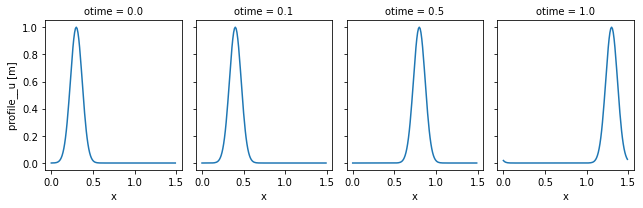

In [190]:
out_ds.profile__u.plot(col='otime', figsize=(9, 3));

In [ ]:
I should use an index for components! initialize in model assembly!



In [179]:
okay,so let's actually start and build a new chemostat prototype

Needs to be able to:
    - flexible addition & interaction of state variables
    - allow for solve via run_step AND odeint or solve_ivp
    

SyntaxError: invalid syntax (<ipython-input-179-845d965c17f0>, line 1)

In [ ]:
@xs.process
class Phytoplankton:
    label_prefix = xs.variable(default='P')
    np = xs.variable(description='number of instances')
    
    #np = xs.index(dims='p_number')
    # note `dims` that allows either a unique instance or multiple instances
    label = xs.variable(dims=[(),'p_number'], groups='label', intent='out')
    init = xs.variable(dims=[(), 'p_number'], intent='in', groups='init')
    size = xs.variable(dims=[(), 'p_number'], intent='in', groups='size')

    # this component property is the same for all instances
    param1 = xs.variable()

    # this component property might have different values for instances
    param2 = xs.variable(dims=[(),'p_number'])

    def initialize(self):
        if self.np:
            self.label = np.array([f"{self.label_prefix}-{i+1}" for i in range(self.np)])
        else:
            self.label = self.label_prefix
        
    def run_step(self):
        print(self.label)
        print(self.param2)

In [ ]:

@xs.process
class Chemostat:
    
    inputs = xs.group('input')
    outputs = xs.group('output')
    
    components = xs.group('component')
    init_values = xs.group('init')
    
    
    